### Objective

The objective of the `Clariface` project is to leverage AI, particularly a convolutional neural network model, to enhance the resolution of human face images.

Here are a few potential use cases for this model:

- **Video Conferencing:** Improving the resolution of human faces in video conferencing applications can enhance the overall visual quality of the communication, leading to a more engaging and productive experience.

- **Medical Imaging:** In medical imaging applications, enhancing the resolution of facial images can be beneficial for dermatologists and plastic surgeons to better analyze skin conditions and plan treatments.

- **Forensics:** In forensic investigations, enhancing the resolution of facial images from security cameras or other sources can assist in identifying suspects or victims in criminal cases.

- **Entertainment Industry:** In film and television production, enhancing the resolution of facial images can be used for digital makeup, facial expression analysis, and other visual effects.

- **Personal Photography:** Enhancing the resolution of human faces in personal photographs can improve the overall quality of the images, making them more suitable for printing or sharing on social media.

- **Artificial Intelligence:** Enhanced facial images can be used as inputs for other AI applications, such as facial recognition systems or emotion detection algorithms, improving their accuracy and performance.


### Loading the dataset

To train our model, we will utilize a dataset comprising approximately 7000 human face images sourced from Kaggle.

In [1]:
# download ashwingupta3012/human-faces dataset from kaggle
!kaggle datasets download -d ashwingupta3012/human-faces

Dataset URL: https://www.kaggle.com/datasets/ashwingupta3012/human-faces
License(s): CC0-1.0
 99% 1.81G/1.82G [00:25<00:00, 40.1MB/s]
100% 1.82G/1.82G [00:25<00:00, 75.6MB/s]


In [2]:
# unzip data into human_faces directory
!unzip -q human-faces.zip -d human_faces

### EDA
First, we'll look at a sample image in the dataset.

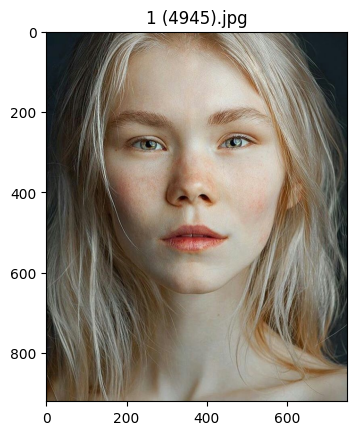

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

random.seed(8)
data_dir = 'human_faces/Humans'

# Get a random image filename from the "human_faces" directory.
image_filenames = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
random_image_filename = random.choice(image_filenames)

# Load the image using matplotlib.
image_path = os.path.join(data_dir, random_image_filename)
image = mpimg.imread(image_path)

# Display the image using matplotlib.
plt.imshow(image)
plt.title(random_image_filename)
plt.show()


The dataset consists of images with different sizes. To accelerate model training, we will standardize all images to a size of 128 x 128 pixels, which will be used as the model's target. Subsequently, we will further decrease the image resolutions to 32 x 32 pixels to serve as inputs for the model.

To demonstrate this proces, we will examine a sample image from the dataset and compare its original, resized, and reduced versions.

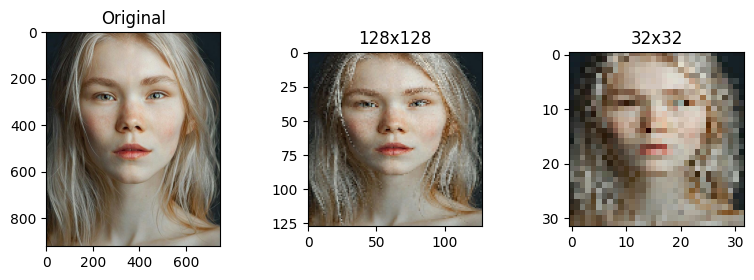

In [10]:
import cv2

image_size = 128  # resize all images to a uniform size
reduced_size = 32  # reduced image size to create training data

def resize_image(image, target_size):
  # Resize the image to the desired size.
  resized_image = cv2.resize(image, (target_size, target_size))
  return resized_image

# Load the images.
image_original = mpimg.imread(os.path.join(data_dir, random_image_filename))
image_hr = resize_image(image_original, image_size)
image_lr = resize_image(image_original, reduced_size)

# Create a figure with three subplots.
fig, axes = plt.subplots(1, 3, figsize=(9,3))

# Display the original image.
axes[0].imshow(image_original)
axes[0].set_title("Original")

# Display the resized (high-resolution) image.
axes[1].imshow(image_hr)
axes[1].set_title(f"{image_size}x{image_size}")

# Display the resized (low-resolution) image.
axes[2].imshow(image_lr)
axes[2].set_title(f"{reduced_size}x{reduced_size}")

# Show the plot.
plt.subplots_adjust(wspace=0.5)  # Adjust the width spacing
plt.show()


### Preprocess image data

Here, we define a function that loads the raw images and generates resized and reduced versions as NumPy arrays. Additionally, we will convert the images to grayscale to enhance the training speed and reduce the computational cost of the model.

In [8]:
import numpy as np
from tqdm import tqdm

# Load and preprocess data
def load_images(folder, image_size, reduced_size):
    images_hr, images_lr = [], []
    for filename in tqdm(image_filenames, desc=f'processing {folder}, {image_size}->{reduced_size}'):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)  # convert to BW to reduce training time
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0  # Normalize to [0, 1]
        images_hr.append(img)

        img = cv2.resize(img, (reduced_size, reduced_size))
        images_lr.append(img)
    return np.array(images_hr), np.array(images_lr)

faces_hr, faces_lr = load_images(data_dir, image_size, reduced_size)


processing human_faces/Humans, 128->32: 100%|██████████| 6973/6973 [01:44<00:00, 66.81it/s]


We will inspect a sample image to verify that the preprocessing has been executed correctly.

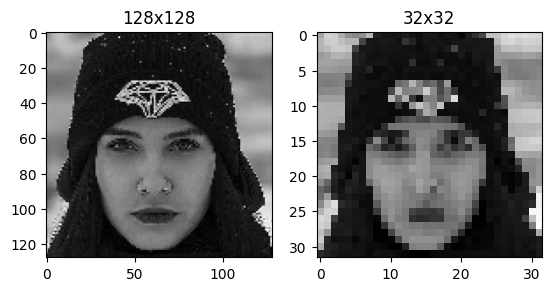

In [11]:
# Choose a random index from the faces_hr and faces_lr arrays.
np.random.seed(8)
random_index = np.random.randint(0, faces_hr.shape[0])

# Create a figure with two subplots.
fig, axes = plt.subplots(1, 2)

# Display the high-resolution image on the left.
axes[0].imshow(faces_hr[random_index], cmap='gray')
axes[0].set_title(f"{image_size}x{image_size}")

# Display the low-resolution image on the right.
axes[1].imshow(faces_lr[random_index], cmap='gray')
axes[1].set_title(f"{reduced_size}x{reduced_size}")

# Show the plot.
plt.show()


We will allocate 80% of the images for training and reserve the remaining 20% for testing.

In [12]:
# create train test split indices
from sklearn.model_selection import train_test_split

# Split the data into train and test sets.
train_indices, test_indices = train_test_split(np.arange(faces_hr.shape[0]), test_size=0.2, random_state=8)

# Get the train and test data.
faces_hr_train = faces_hr[train_indices]
faces_lr_train = faces_lr[train_indices]
faces_hr_test = faces_hr[test_indices]
faces_lr_test = faces_lr[test_indices]


### Create and train the model

The model is a convolutional neural network (CNN) designed for image super-resolution, specifically aimed at increasing the resolution of grayscale images. It consists of several layers, starting with an input layer shaped for 32x32 pixel grayscale images. The model uses a series of convolutional layers with rectified linear unit (ReLU) activation functions and batch normalization to extract features and upscale the image. The upsampling is done using two layers of upsampling, followed by convolutional layers to refine the details. The final layer uses a sigmoid activation function to map the pixel values between 0 and 1. The model is compiled using the Adam optimizer and mean squared error (MSE) loss function, which is suitable for regression tasks like image super-resolution.


In [100]:
import tensorflow as tf
from tensorflow.keras import layers

# Define and compile the model1 (using UpSampling2D)
model1 = tf.keras.Sequential([
    layers.Input(shape=(32, 32, 1)),  # Input shape for 32x32 grayscale images

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.UpSampling2D((2, 2), interpolation='nearest'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.UpSampling2D((2, 2), interpolation='bilinear'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
], name = 'model1')

model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 conv2d_92 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_38 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 up_sampling2d_6 (UpSamplin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_39 (Ba  (None, 64, 64, 64)        256  

The model is trained using the `fit` method on the training data, `faces_lr_train` and `faces_hr_train`, which are the low-resolution and high-resolution images, respectively.
We use a validation split of 0.2, meaning 20% of the training data is used for validation. The `epochs` parameter is set to 10, indicating the number of times the entire dataset is passed through the neural network. A `batch_size` of 32 is used, which means that the model is updated based on 32 samples at a time.

Additionally, an `EarlyStopping` callback is employed to monitor the validation loss (`val_loss`). If the validation loss does not decrease by at least 0.0005 for 3 consecutive epochs (`patience=3`), training will stop.

In [101]:
# Training the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=3, verbose=1)  # add early stopping callback

model1_history = model1.fit(faces_lr_train, faces_hr_train, validation_split=0.2, epochs=10, batch_size=32,
                          callbacks=[early_stopping])


Epoch 1/10
140/140 [==============================] - 20s 117ms/step - loss: 0.0083 - val_loss: 0.0654
Epoch 2/10
140/140 [==============================] - 16s 116ms/step - loss: 0.0061 - val_loss: 0.0506
Epoch 3/10
140/140 [==============================] - 16s 113ms/step - loss: 0.0058 - val_loss: 0.0202
Epoch 4/10
140/140 [==============================] - 16s 113ms/step - loss: 0.0054 - val_loss: 0.0090
Epoch 5/10
140/140 [==============================] - 16s 115ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 6/10
140/140 [==============================] - 16s 114ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 7/10
140/140 [==============================] - 16s 115ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 8/10
140/140 [==============================] - 16s 115ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 8: early stopping


### Test the model performance

The model's performance is assessed by visualizing the reduced, predicted, and true high-resolution images. For a given image index from the test set, the low-resolution image is retrieved, and the model predicts the corresponding high-resolution image. These images, along with the true high-resolution image from the test set, are displayed side by side in a figure with three subplots. To experiment with multiple model architectures, we'll write a function that accepts a list of models and plots predictions from each.

In [103]:
# Testing the model performance: visualizng the reduced, predicted, and true images

def plot_predictions(models, test_image_index):
  # Get the low-resolution image.
  image_lr = faces_lr_test[test_image_index]

  n_images = len(models) + 2  # Reduced + True + Model predictions

  # Create a figure with three subplots.
  fig, axes = plt.subplots(1, n_images, figsize=(n_images*4, 4))

  # Display the low-resolution image.
  axes[0].imshow(image_lr, cmap='gray')
  axes[0].set_title(f"Reduced [{reduced_size}x{reduced_size}]")

  # Predict the high-resolution image using the model.
  for i, model in enumerate(models):
    image_hr_predicted = model.predict(np.expand_dims(image_lr, axis=0))[0]

    # Display the predicted high-resolution image.
    axes[i+1].imshow(image_hr_predicted, cmap='gray')
    axes[i+1].set_title(f"{model.name} prediction [{image_size}x{image_size}]")

  # Display the true high-resolution image.
  axes[-1].imshow(faces_hr_test[test_image_index], cmap='gray')
  axes[-1].set_title(f"True [{image_size}x{image_size}]")

  # Show the plot.
  plt.show()


1/1 [==============================] - 0s 18ms/step


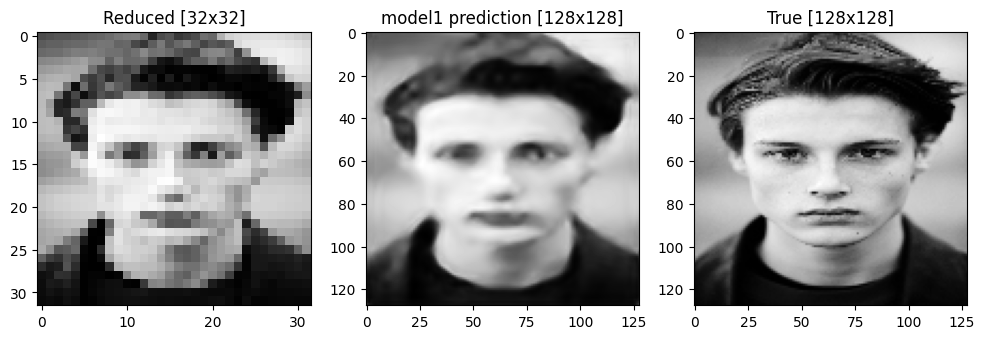

In [104]:
# Choose a sample from the test set.
test_image_index = 42

plot_predictions([model1], test_image_index)

Not bad, but we might be able to improve the model using `Conv2dTranspose` layers instead of `UpSampling2D`.

### Conv2DTranspose

`Conv2DTranspose`, also known as a transposed convolution or deconvolution, is a type of layer used in neural networks to perform upsampling. It essentially performs the reverse operation of a convolution, expanding the spatial dimensions (height and width) of the input while learning to generate high-resolution outputs from low-resolution inputs through learned filters.


Conv2DTranspose is usually better than Simple Upsampling for image resolution enhancement. The reason is Conv2DTranspose learns filters that can adapt to the data, enabling the network to generate higher quality and more complex upscaled images. While simple Upsampling uses fixed, non-learned methods like nearest-neighbor or bilinear interpolation, which cannot capture complex patterns.


In [107]:
# Define and compile model2 (using Conv2DTranspose)

model2 = tf.keras.Sequential([
    layers.Input(shape=(32, 32, 1)),  # Input shape for 32x32 grayscale images

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
], name = 'model2')

model2.compile(optimizer='adam', loss='mse')
model2.summary()


Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 32, 32, 64)        640       
                                                                 
 conv2d_109 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_45 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_transpose_35 (Conv2  (None, 64, 64, 64)        36928     
 DTranspose)                                                     
                                                                 
 conv2d_110 (Conv2D)         (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_46 (Ba  (None, 64, 64, 64)        256  

In [108]:
model2_history = model2.fit(faces_lr_train, faces_hr_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
140/140 [==============================] - 25s 147ms/step - loss: 0.0089 - val_loss: 0.0752
Epoch 2/10
140/140 [==============================] - 19s 135ms/step - loss: 0.0059 - val_loss: 0.0563
Epoch 3/10
140/140 [==============================] - 19s 136ms/step - loss: 0.0055 - val_loss: 0.0290
Epoch 4/10
140/140 [==============================] - 19s 138ms/step - loss: 0.0055 - val_loss: 0.0085
Epoch 5/10
140/140 [==============================] - 20s 145ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 6/10
140/140 [==============================] - 21s 147ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 7/10
140/140 [==============================] - 20s 145ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 8/10
140/140 [==============================] - 21s 151ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 9/10
140/140 [==============================] - 21s 147ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 10/10
140/140 [==============================] - 20s 143ms/step - l

1/1 [==============================] - 0s 19ms/step


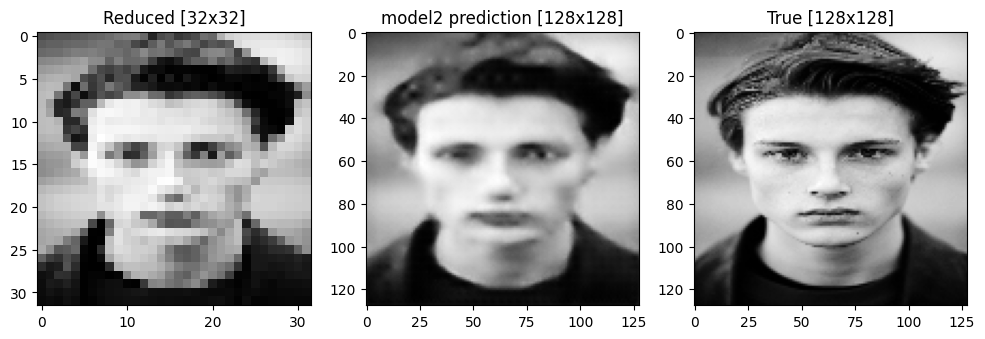

In [116]:
# Testing model2 performance

plot_predictions([model2], test_image_index)

Model 2 predictions seem slighly better. Let's try another model using Conv2DTranspose layers with multiple kernel sizes.

For this architecture, we need to use the Functional API.

In [122]:
# Define and compile model3 (using Conv2DTranspose with multiple kernel sizes)

inputs = tf.keras.Input(shape=(32, 32, 1))

# Conv2D blocks
conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)

# First Conv2DTranspose block with multiple kernel sizes
up1_1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv2)
up1_2 = layers.Conv2DTranspose(64, (1, 1), strides=(2, 2), padding='same', activation='relu')(conv2)
up1_3 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(conv2)

concat1 = layers.concatenate([up1_1, up1_2, up1_3])
bn1 = layers.BatchNormalization()(concat1)

# Second Conv2DTranspose block with multiple kernel sizes
up2_1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(bn1)
up2_2 = layers.Conv2DTranspose(64, (1, 1), strides=(2, 2), padding='same', activation='relu')(bn1)
up2_3 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(bn1)

concat2 = layers.concatenate([up2_1, up2_2, up2_3])
bn2 = layers.BatchNormalization()(concat2)

# Conv2D blocks
conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(bn2)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)

# Final Conv2D layer
outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv4)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model3')

model3.compile(optimizer='adam', loss='mse')
model3.summary()


Model: "model3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_136 (Conv2D)         (None, 32, 32, 64)           640       ['input_29[0][0]']            
                                                                                                  
 conv2d_137 (Conv2D)         (None, 32, 32, 64)           36928     ['conv2d_136[0][0]']          
                                                                                                  
 conv2d_transpose_65 (Conv2  (None, 64, 64, 64)           36928     ['conv2d_137[0][0]']          
 DTranspose)                                                                                 

In [123]:
model3_history = model3.fit(faces_lr_train, faces_hr_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
140/140 [==============================] - 70s 394ms/step - loss: 0.0084 - val_loss: 0.1084
Epoch 2/10
140/140 [==============================] - 42s 296ms/step - loss: 0.0057 - val_loss: 0.0977
Epoch 3/10
140/140 [==============================] - 43s 308ms/step - loss: 0.0054 - val_loss: 0.0714
Epoch 4/10
140/140 [==============================] - 41s 295ms/step - loss: 0.0053 - val_loss: 0.0167
Epoch 5/10
140/140 [==============================] - 41s 294ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 6/10
140/140 [==============================] - 43s 307ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 7/10
140/140 [==============================] - 41s 295ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/10
140/140 [==============================] - 41s 293ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 9/10
140/140 [==============================] - 41s 294ms/step - loss: 0.0048 - val_loss: 0.0062
Epoch 9: early stopping


1/1 [==============================] - 1s 1s/step


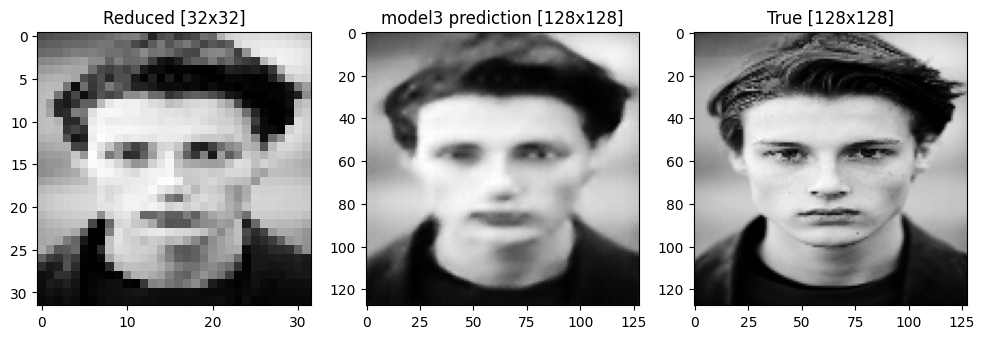

In [124]:
# Testing model3 performance
plot_predictions([model3], test_image_index)

1/1 [==============================] - 0s 19ms/step


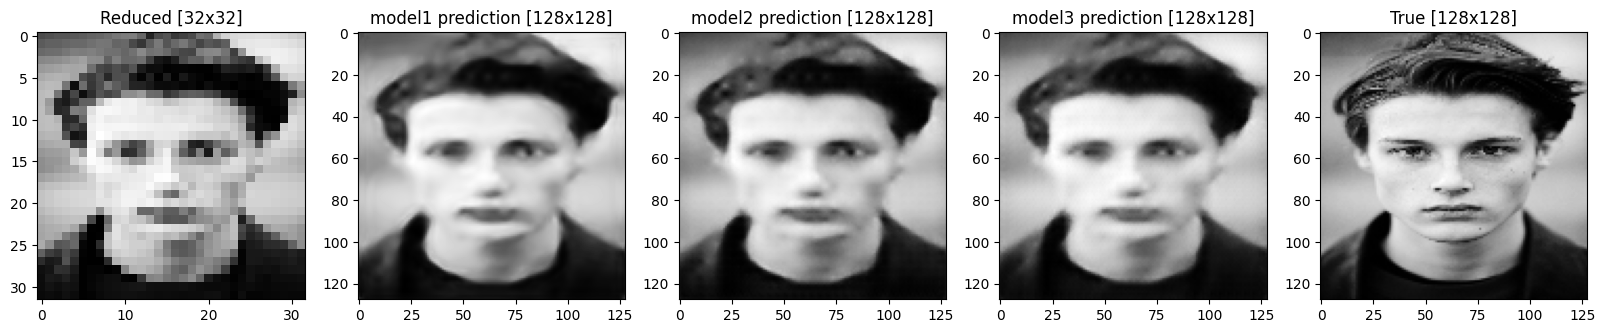

In [ ]:
# Comparing predictions from different models

plot_predictions([model1, model2, model3], test_image_index)

Here is a comparison of Model 1 (Upsampling), Model 2 (Conv2DTranspose), and Model 3 (Conv2DTranspose with multiple kernel sizes) in terms of training and validation loss:

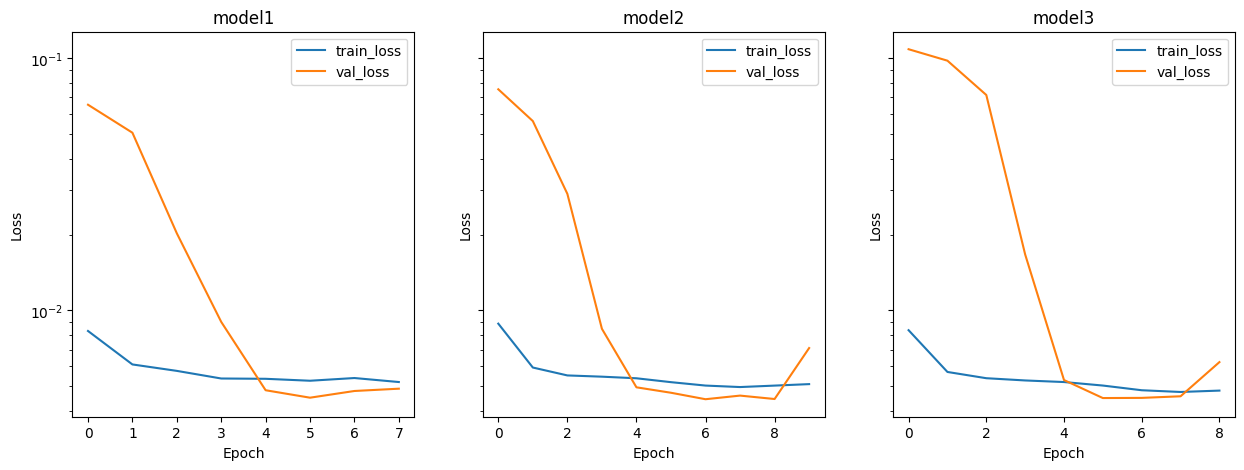

In [136]:
# Create a figure with two subplots.
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot the training loss for both models.
for i, model_history in enumerate([model1_history, model2_history, model3_history]):
    axes[i].plot(model_history.history['loss'], label='train_loss')
    axes[i].plot(model_history.history['val_loss'], label='val_loss')
    axes[i].set_title(model_history.model.name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].set_yscale('log')
    axes[i].legend()

plt.show()